In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as lng
import scipy.io as io
from sklearn.ensemble import BaggingClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from pathlib import Path
import pandas as pd
import seaborn as sns

In [3]:
data_file = "processed_data.csv"
d = pd.read_csv(data_file)

## Vi bliver ikke bedømt på fly hvor der er nul passagerer
d = d[d.LoadFactor != 0]

## Splits
d.ScheduleTime = pd.to_datetime(d.ScheduleTime)
ix_val = ((d.ScheduleTime.dt.year==2022) & (d.ScheduleTime.dt.month!=1))

## Fjerner udvalgte kolonner da de allerede er blevet encoded som sin/cos
## Eller hvis kolonnen kun indehodler identiske værdier
X_cols = list(d.columns)
X_cols.remove("LoadFactor")
X_cols.remove("ScheduleTime")
X_cols.remove('Hour')
X_cols.remove('Date')
X_cols.remove('QuarterEnd')
X_cols.remove('MonthEnd')
X_cols.remove('TimeToQuarterEnd')
X_cols.remove('TimeToMonthEnd')
X_cols.remove('Holiday')

## One-hot encoding
d_one_hot = pd.get_dummies(d[X_cols],)

## Alternativ til One-hot encoding af features med mange levels
## Der udregnes middelværdi og precision (inverse variance) af LoadFactor, for hvert
## unikt level. Eks: For alle observationer flynummer SA201, udregnes der middelværdi og precision
## Disse summary metrics tilføjes som features
for col in ["FlightNumber2","Airline","Sector","Destination","AircraftType"]:
    mu = d[~ix_val].groupby(col)["LoadFactor"].mean()
    prec = 1/d[~ix_val].groupby(col)["LoadFactor"].var()

    mu = d[col].map(mu)
    prec = d[col].map(prec)
    mu[mu.isna()|np.isinf(mu)] = 0
    prec[prec.isna()|np.isinf(prec)] = 0

    col_mean = "mean_"+col
    col_prec = "prec_"+col

    d_one_hot[col_mean] = mu
    d_one_hot[col_prec] = prec


cols_mu = d_one_hot.columns.str.startswith("_mean")
cols_prec = d_one_hot.columns.str.startswith("_prec")

cols_flight_numbers = d_one_hot.columns.str.startswith("FlightNumber2")
cols_airline = d_one_hot.columns.str.startswith("Airline")
cols_sector = d_one_hot.columns.str.startswith("Sector")
cols_destination = d_one_hot.columns.str.startswith("Destination")
cols_aircraft = d_one_hot.columns.str.startswith("AircraftType")
cols_one_hot = (cols_flight_numbers | cols_airline | cols_sector | cols_destination | cols_aircraft)


## Standardisering
X = (d_one_hot-d_one_hot.mean(axis=0))/d_one_hot.std(axis=0)


## To datamatrixer: En med alt one-hot encoded og en anden hvor mean+precision benyttes
## for udvalgte features.
X_full_cols = d_one_hot.columns[~(cols_mu | cols_prec)]
X_small_cols = d_one_hot.columns[~cols_one_hot]

X_full = X[X_full_cols].to_numpy()
X_small = X[X_small_cols].to_numpy()
y = d.LoadFactor.iloc[:].to_numpy()

N, P_full = X_full.shape
N, P_small = X_small.shape

FlightNumber2
Airline
Sector
Destination
AircraftType


In [4]:
## Metrics

def relative_difference(y,y_hat):
    return (y-y_hat)/y
def accuracy(y,y_hat):
    return (1-np.abs(relative_difference(y,y_hat)))*100

## Trees

Fitting 5 folds for each of 40 candidates, totalling 200 fits
best estimator: DecisionTreeRegressor(min_samples_leaf=61)


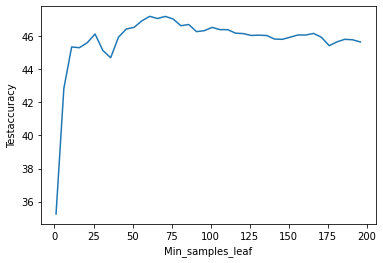

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer


trns = lambda x: x
inv_trns = lambda x: x

def accuracy_score(y_true, y_pred):
    return accuracy(y_true,inv_trns(y_pred)).mean()

score = make_scorer(accuracy_score, greater_is_better=True)


dtree=DecisionTreeRegressor()

candidates = range(1,200,5)

X_train = X_small[~ix_val,:]
y_train = y[~ix_val]
X_val = X_small[ix_val,:]
y_val = y[ix_val]

param_grid = {
    'min_samples_leaf': candidates,
    
}
cv_grid = GridSearchCV(estimator = dtree, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1,scoring=score)

# Fit the grid search model
cv_grid.fit(X_train, trns(y_train))

#plot the results
plt.plot(candidates,cv_grid.cv_results_['mean_test_score'])
plt.xlabel('Min_samples_leaf')
plt.ylabel('Testaccuracy')
print(f'best estimator: {cv_grid.best_estimator_}')

Accuracy train
67.69080754372692
Accuracy val
57.56111768362041


/home/hinge/.venv/MRI-to-PET/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Validation predictions')

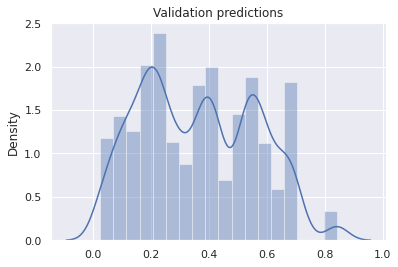

In [35]:
from sklearn import tree
dtree=DecisionTreeRegressor(min_samples_leaf=71)
dtree.fit(X_train, trns(y_train))

print("Accuracy train")
yhat = inv_trns(dtree.predict(X_train))
print(accuracy(y_train,yhat).mean())

print("Accuracy val")
yhat = inv_trns(dtree.predict(X_val))
print(accuracy(y_val,yhat).mean())

sns.distplot(yhat)
plt.title("Validation predictions")



Accuracy before: 60.17
Accuracy with threshhold of 0.0031622776601683794: 60.17


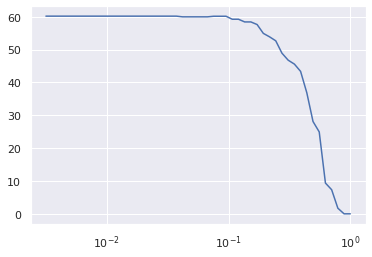

In [7]:
threshholds = np.logspace(-2.5,0,num=50)
accuracies = np.zeros(threshholds.shape)
for i,thresh in enumerate(threshholds):
    pred_thresh = yhat*(yhat>thresh)
    accuracies[i] = accuracy(y_val,pred_thresh).mean()

sns.set_theme()
plt.semilogx(threshholds,accuracies)

print("Accuracy before: {:.4}".format(accuracy(y_val,yhat).mean()))
best_ix = np.argmax(accuracies)
print("Accuracy with threshhold of {:}: {:.4}".format(threshholds[best_ix],accuracies[best_ix]))

## Dummy predictor

In [8]:
from sklearn.dummy import DummyRegressor

dummy_clf = DummyRegressor(strategy='mean')
dummy_clf.fit(X,y)
y_hat = dummy_clf.predict(X)
# Check for Model Accuracy
print("without log transform",accuracy(y,y_hat).mean())

dummy_clf = DummyRegressor(strategy='mean')
dummy_clf.fit(X,np.log(y))
y_hat = np.exp(dummy_clf.predict(X))
# Check for Model Accuracy
print("with log transform",accuracy(y,y_hat).mean())




without log transform -22.112453290156218
with log transform -1.946038032479979


# KNN

Best 7 neighbors, acc: 59.91806257298028


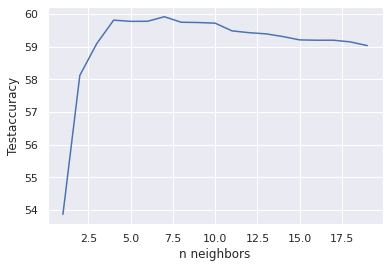

In [16]:
from sklearn.neighbors import KNeighborsRegressor
trns = lambda x: np.log(x)
inv_trns = lambda x: np.exp(x)

candidates = range(1,20,1)

scores = []
for candidate in candidates:
    model = KNeighborsRegressor(n_neighbors=candidate)
    # Fit the grid search model
    model.fit(X_train,trns(y_train))
    yhat = inv_trns(model.predict(X_val))
    scores.append(accuracy(y_val,yhat).mean())

#plot the results
plt.plot(candidates,scores)
plt.xlabel('n neighbors')
plt.ylabel('Testaccuracy')
ix = np.argmax(scores)
print("Best",candidates[ix],"neighbors, acc:",scores[ix])


In [17]:
model = KNeighborsRegressor(n_neighbors=7)
model.fit(X_train,trns(y_train))
yhat = inv_trns(model.predict(X_val))




Flights with very low true loadfactor cause a huge negative relative difference due to division by something close to 0.

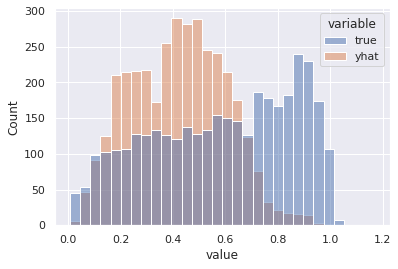

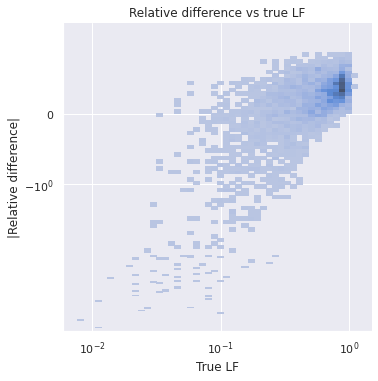

In [20]:
    
result = pd.DataFrame({"true":y_val,"yhat":yhat}).melt()
rd = relative_difference(y_val,yhat)
sns.histplot(data=result,x="value",hue="variable")

sns.displot(x=y_val,y=rd,log_scale=(True, False))
plt.xlabel("True LF")
plt.ylabel("|Relative difference|")
plt.title("Relative difference vs true LF")
plt.yscale('symlog')


An example of the shitty case:

In [21]:
acc = accuracy(y_val,yhat)
print("Relative difference:",np.min(acc))
d.iloc[np.argmin(acc),:]

Relative difference: -662.4377537316643


ScheduleTime                  2021-03-27 14:50:00
Airline                                        CN
Destination                                   EST
AircraftType                                  AT7
FlightType                                      J
Sector                                         US
SeatCapacity                                   72
LoadFactor                               0.902778
Hour                                           14
Date                                   2021-03-27
Holiday                                      True
Weekday                                  Saturday
QuarterEnd          2021-03-31 23:59:59.999999999
MonthEnd            2021-03-31 23:59:59.999999999
TimeToQuarterEnd                                4
TimeToMonthEnd                                  4
TimeCos                                 -0.737277
TimeSin                                  -0.67559
DayCos                                   0.669131
DaySin                                  -0.743145


## A simple yet effective fix
All flights that are succeptible to having a very load loadfactor, we simply predict to have 0 passengers

Accuracy before: 59.92
Accuracy with threshhold of 0.06707035611184306: 60.05


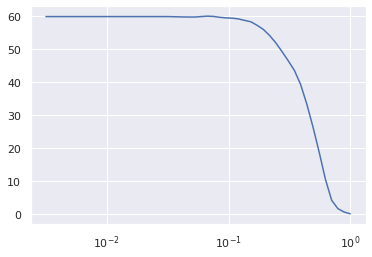

In [22]:
threshholds = np.logspace(-2.5,0,num=50)
accuracies = np.zeros(threshholds.shape)
for i,thresh in enumerate(threshholds):
    pred_thresh = yhat*(yhat>thresh)
    accuracies[i] = accuracy(y_val,pred_thresh).mean()

sns.set_theme()
plt.semilogx(threshholds,accuracies)

print("Accuracy before: {:.4}".format(accuracy(y_val,yhat).mean()))
best_ix = np.argmax(accuracies)
print("Accuracy with threshhold of {:}: {:.4}".format(threshholds[best_ix],accuracies[best_ix]))

## No transform and exp transform is shitty

In [406]:
model = KNeighborsRegressor(n_neighbors=7)
model.fit(X_small,np.exp(y))
y_pred = model.predict(X_small)
print(accuracy(y,np.log(y_pred)).mean())

12.810892871283368


In [407]:
model = KNeighborsRegressor(n_neighbors=7)
model.fit(X_small,y)
y_pred = model.predict(X_small)
print(accuracy(y,y_pred).mean())

19.60126571919451


## Inverse transformation is alright

In [28]:
model = KNeighborsRegressor(n_neighbors=7)
trns = lambda x: 1/x
inv_trns = lambda x: 1/x

model.fit(X_train,trns(y_train))
yhat = inv_trns(model.predict(X_val))
print(accuracy(y_val,yhat).mean())

59.01639217570004


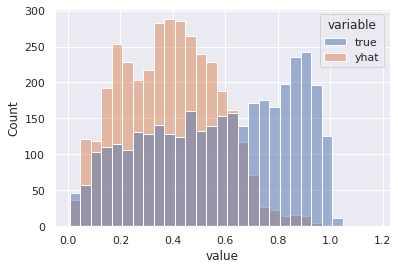

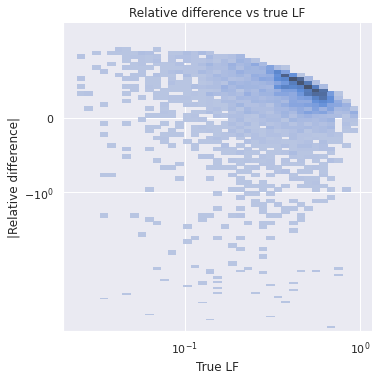

In [30]:
result = pd.DataFrame({"true":y_val,"yhat":yhat}).melt()
rd = relative_difference(y_val,yhat)
sns.histplot(data=result,x="value",hue="variable")

sns.displot(x=yhat,y=rd,log_scale=(True, False))
plt.xlabel("True LF")
plt.ylabel("|Relative difference|")
plt.title("Relative difference vs true LF")
plt.yscale('symlog')

Little improvement by threshholding

Accuracy before: 59.02
Accuracy with threshhold of 0.0031622776601683794: 59.02


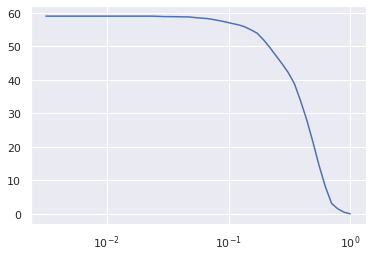

In [32]:
threshholds = np.logspace(-2.5,0,num=50)
accuracies = np.zeros(threshholds.shape)
for i,thresh in enumerate(threshholds):
    pred_thresh = yhat*(yhat>thresh)
    accuracies[i] = accuracy(y_val,pred_thresh).mean()

sns.set_theme()
plt.semilogx(threshholds,accuracies)

print("Accuracy before: {:.4}".format(accuracy(y_val,yhat).mean()))
best_ix = np.argmax(accuracies)
print("Accuracy with threshhold of {:}: {:.4}".format(threshholds[best_ix],accuracies[best_ix]))